In [ ]:
import pandas as pd 
import numpy as np
from functools import partial
from glob import glob

from pymongo import MongoClient

import statsmodels.api as sm
import scipy

from utils.misc import read_mongo, batch
from utils.geolocation import CachedGeolocator, region_fixer, locality_fixer, countryName_fixer, address_to_location
from utils.dk021 import DK021
from utils.etl import transform_dataset

%matplotlib inline

In [ ]:
sns.set_style("whitegrid")

# Prepare data

## Transform Chunked

In [ ]:
batch_size = 50_000

# connect to tenders db
cursor = MongoClient()['prozorro']['etenders'].find(no_cursor_timeout=True)

try:
    for idx, b in enumerate(batch(cursor, batch_size)):

        transform_dataset(
            df=pd.DataFrame(b).rename(columns={'_id':'id'})
        ).to_parquet(f'./data/prepared/chunk_{idx}.parquet.gzip', compression='gzip') 

        print(f'chunk {idx}')
# except Exception as e:
#     print(e)
finally:
    cursor.close()

## Restore & enrich

In [ ]:
files = sorted(glob('./data/prepared/chunk_*.parquet.gzip'))

full_df = pd.read_parquet(files[0])
for f in files[1:]:
    full_df = pd.concat([full_df, pd.read_parquet(f)])


In [ ]:
classifier = DK021.load('./data/dk021.csv')

In [ ]:
classifier.get_level_category('33141113-4', level=5).description

'Бинти'

In [ ]:
# geo and classifier
fixers = {
    'locality': locality_fixer,
    'region': region_fixer,
    'countryName': countryName_fixer
}
geolocator = CachedGeolocator(cache_dir='./data/geo_cache', bad_cache_dir='./data/geo_cache_bad', verbose=False)
get_location = partial(address_to_location, geolocator=geolocator, fixers=fixers)
classifier = DK021.load('./data/dk021.csv')

full_df = (
    full_df
    .query('~items_code.isna()')
    .assign(
        items_classification_l1 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=1).code),
        items_classification_l2 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=2).code),
        items_classification_l3 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=3).code)
    )
    .assign(
        procuringEntity_geo = lambda d: d.procuringEntity_address.apply(lambda address:get_location(address)),
        bids_tenderers_geo = lambda d: d.tenderers_address.apply(lambda address:get_location(address)),
    )
)

geolocator.close()

# Read data

In [ ]:
from utils.misc import mem_usg

classifier = DK021.load('./data/dk021.csv')
full_df = pd.read_parquet('../full.parquet.gzip')

mem_usg(full_df)/(1024*1024)

5108.999673843384

In [ ]:
full_df.head()

,id,date,dateModified,tenderID,owner,procurementMethod,submissionMethod,numberOfBids,status,procurementMethodType,...,awards_value_amount,awards_value_currency,awards_value_valueAddedTaxIncluded,items_code,items_classification_l1,items_classification_l2,items_classification_l3,procuringEntity_geo,bids_tenderers_geo,geo_distance
0,54c44b64ee504474afaf1183c410b36c,2018-12-31 22:03:03.722108+00:00,2018-12-31 22:03:03.722108+00:00,UA-2018-11-15-000962-c,it.ua,open,electronicAuction,2,unsuccessful,aboveThresholdUA,...,279770.40,UAH,False,72610000-9,72000000-5,72600000-6,72610000-9,"[47.4970865, 34.6487214]","[49.9923181, 36.2310146]",300.877064
1,54c44b64ee504474afaf1183c410b36c,2018-12-31 22:03:03.722108+00:00,2018-12-31 22:03:03.722108+00:00,UA-2018-11-15-000962-c,it.ua,open,electronicAuction,2,unsuccessful,aboveThresholdUA,...,280612.08,UAH,False,72610000-9,72000000-5,72600000-6,72610000-9,"[47.4970865, 34.6487214]","[49.5897423, 34.5507948]",232.817393
2,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,735000.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]","[49.7132963, 37.6141992]",0.000000
3,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,734650.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]",None,NaN
4,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,867200.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]","[49.9923181, 36.2310146]",104.197987


## Explore

In [ ]:
full_df.geo_distance.isna().value_counts()

False    2154765
True      218044
Name: geo_distance, dtype: int64

In [ ]:
full_df.awards_status.value_counts()

active          894256
unsuccessful    318514
cancelled        61464
pending          29395
Name: awards_status, dtype: int64

In [ ]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9'][["id", "lots_id", "bids_value_amount", "value_amount", "awards_value_amount", "procurementMethodType", "awards_status"]]

,id,lots_id,bids_value_amount,value_amount,awards_value_amount,procurementMethodType,awards_status
76067,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1052085.85,1060036.0,NaN,aboveThresholdUA,NaN
76068,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1019377.02,1060036.0,1019377.02,aboveThresholdUA,active
76069,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,2267523.67,2270252.0,NaN,aboveThresholdUA,NaN
76070,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,2266848.50,2270252.0,2266848.50,aboveThresholdUA,active


In [ ]:
full_df.columns

Index(['id', 'date', 'dateModified', 'tenderID', 'owner', 'procurementMethod',
       'submissionMethod', 'numberOfBids', 'status', 'procurementMethodType',
       'mainProcurementCategory', 'procuringEntity_name',
       'procuringEntity_kind', 'procuringEntity_address', 'num_lots',
       'procuringEntity_identifier_id', 'procuringEntity_identifier_scheme',
       'procuringEntity_contactPoint_email',
       'procuringEntity_contactPoint_name',
       'procuringEntity_contactPoint_telephone', 'lots_id', 'value_amount',
       'value_currency', 'value_valueAddedTaxIncluded', 'lots_status',
       'bids_date', 'bids_id', 'bids_status', 'bids_tenderers_name',
       'bids_tenderers_identifier_id', 'bids_tenderers_identifier_scheme',
       'bids_tenderers_contactPoint_email', 'bids_tenderers_contactPoint_name',
       'bids_tenderers_contactPoint_telephone', 'tenderers_address',
       'bids_value_amount', 'bids_value_currency',
       'bids_value_valueAddedTaxIncluded', 'awards_date', 

In [ ]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9']

,id,date,dateModified,tenderID,owner,procurementMethod,submissionMethod,numberOfBids,status,procurementMethodType,...,awards_value_amount,awards_value_currency,awards_value_valueAddedTaxIncluded,items_code,items_classification_l1,items_classification_l2,items_classification_l3,procuringEntity_geo,bids_tenderers_geo,geo_distance
76067,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,NaN,NaN,True,33141113-4,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[48.5167748, 34.6068797]",376.483135
76068,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,1019377.02,UAH,True,33141113-4,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[50.587515499999995, 30.48936284691901]",0.000000
76069,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,NaN,NaN,True,33140000-3,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[48.5167748, 34.6068797]",376.483135
76070,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,2266848.50,UAH,True,33140000-3,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[50.587515499999995, 30.48936284691901]",0.000000


# Hypotheses

## Hypothesis #1

In [ ]:
data_h1 = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [ ]:
num_of_bids_count = (
    data_h1[["id", "numberOfBids"]]
    .groupby(by=["numberOfBids"])
    .agg({
        "id": "count",
    })
    .reset_index()
    .rename(columns={"id": "count"})
    .query("count>1000")
)

<AxesSubplot:xlabel='numberOfBids', ylabel='economy'>

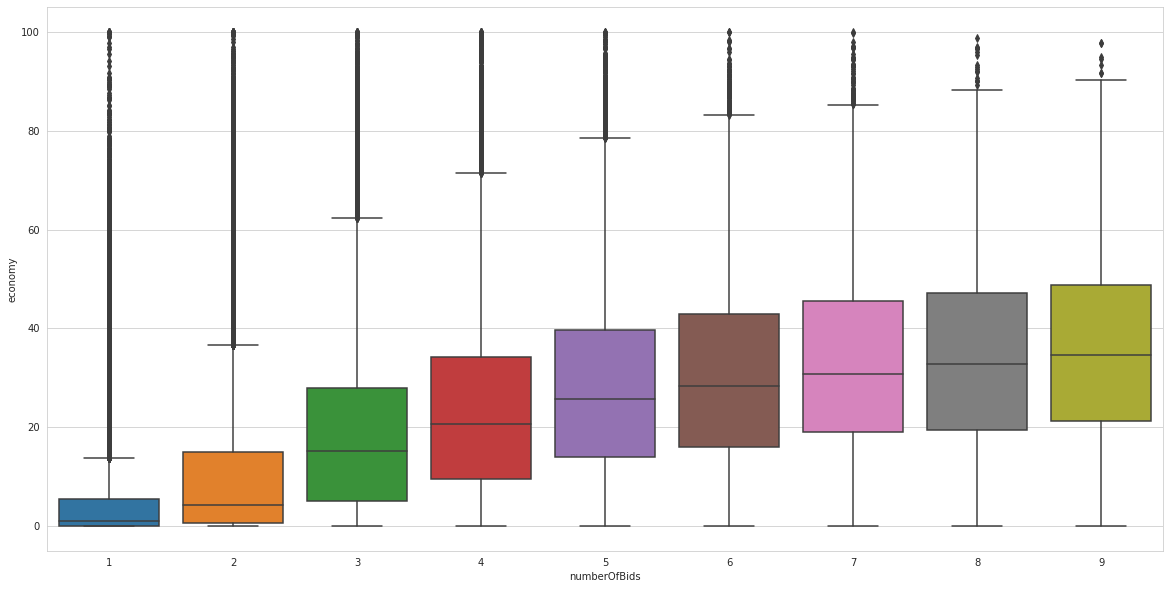

In [ ]:
data_h1_boxplot = data_h1[data_h1["numberOfBids"] < num_of_bids_count["numberOfBids"].max()]

plt.figure(figsize=(20, 10))
sns.boxplot(data=data_h1_boxplot, x="numberOfBids", y="economy")

In [ ]:
for thr in num_of_bids_count["numberOfBids"]:
    above_thr_mask = data_h1["numberOfBids"] > thr
    economy_below_thr = data_h1[~above_thr_mask]["economy"]
    economy_above_thr = data_h1[above_thr_mask]["economy"]
    
    print(f"NumberOfBids>{thr}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(economy_above_thr, economy_below_thr, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than NumberOfBids<={thr}")#" with p-value={pvalue}")
    
    # print(economy_above_thr.var(), economy_below_thr.var())
    # f = economy_above_thr.var() / economy_below_thr.var()
    # pvalue = 1 - scipy.stats.f.cdf(f, len(economy_above_thr) - 1, len(economy_below_thr) - 1)
    
    # levene’s for equal variances
    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than NumberOfBids<={thr}")#" with p-value={pvalue}")

NumberOfBids>1
	has sufficiently higher mean economy than NumberOfBids<=1
	has sufficiently higher economy variance than NumberOfBids<=1
NumberOfBids>2
	has sufficiently higher mean economy than NumberOfBids<=2
	has sufficiently higher economy variance than NumberOfBids<=2
NumberOfBids>3
	has sufficiently higher mean economy than NumberOfBids<=3
	has sufficiently higher economy variance than NumberOfBids<=3
NumberOfBids>4
	has sufficiently higher mean economy than NumberOfBids<=4
	has sufficiently higher economy variance than NumberOfBids<=4
NumberOfBids>5
	has sufficiently higher mean economy than NumberOfBids<=5
	has sufficiently higher economy variance than NumberOfBids<=5
NumberOfBids>6
	has sufficiently higher mean economy than NumberOfBids<=6
	has sufficiently higher economy variance than NumberOfBids<=6
NumberOfBids>7
	has sufficiently higher mean economy than NumberOfBids<=7
	has sufficiently higher economy variance than NumberOfBids<=7
NumberOfBids>8
	has sufficiently higher m

## Hypothesis #2

In [ ]:
region_map_dict = {
    "Киевская": "Київська область",
    "Киевская область": "Київська область",
    "КИЕВСКАЯ ОБЛ.": "Київська область",
    "Київ": "Київська область",
    "Киев": "Київська область",
    "місто Київ": "Київська область",
    "м. Київ": "Київська область",
    "м.Київ": "Київська область",
    "Полтавская область": "Полтавська область",
    "Днепропетровская область": "Дніпропетровська область",
    "Днепропетровская обл.": "Дніпропетровська область",
    "Запорожская область": "Запорізька область",
    "Харьковская область": "Харківська область",
    "Днiпропетровська область": "Дніпропетровська область",
    "дніпропетровська": "Дніпропетровська область",
    "Одесская область": "Одеська область",
}

def format_regions(region: str):
    if not region or region in {"1", "Україна"}:
        return None
    region = region.strip()
    region = region.replace("обл.", "область")
    region = region_map_dict.get(region, region)
    words = region.split(" ")
    if len(words) == 1:
        words.append("область")
    return " ".join(words)

data_h2_orig = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount', 'tenderers_address']]
    .query('numberOfBids>0')
    .reset_index()
)

data_h2 = (
    data_h2_orig
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

regions = (
    data_h2_orig["tenderers_address"]
    .map(lambda x: x["region"])
    .map(format_regions)
)

region_counts = (
    regions
    .to_frame()
    .groupby("tenderers_address")
    .tenderers_address
    .transform("size")
)

data_h2["bids_region"] = regions
data_h2 = data_h2[regions.astype(bool) & (region_counts > 100)]

/home/roman/miniconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<AxesSubplot:xlabel='economy', ylabel='bids_region'>

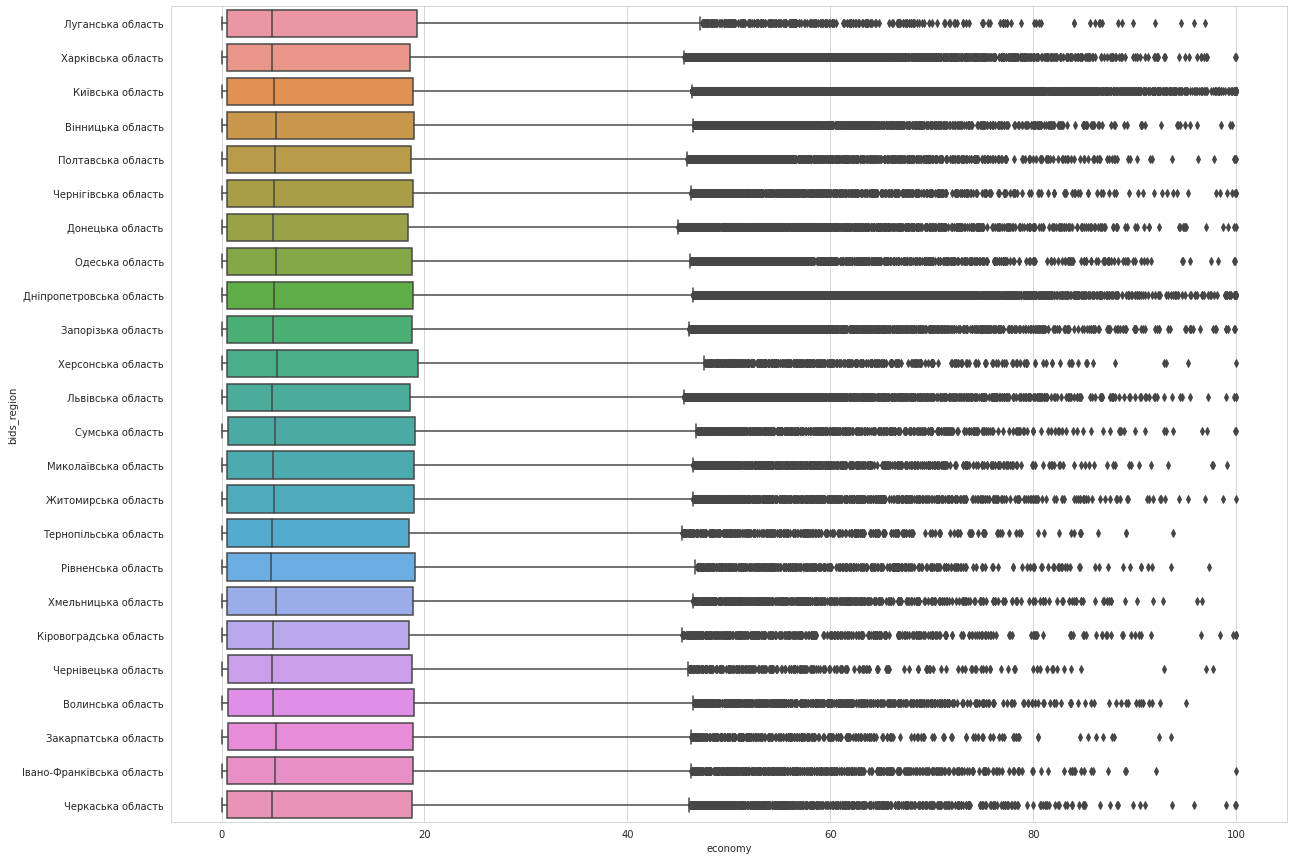

In [ ]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=data_h2, x="economy", y="bids_region")

## Hypothesis #3

In [ ]:
date_grouper = pd.Grouper(key="date", freq="1M")
data_h3 = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids', 'date']]
    .query('numberOfBids>0')
    .groupby([date_grouper, "numberOfBids"])
    .agg({
        "id": "count",
    })
    .rename(columns={"id": "numberOfBidsCount"})
    .groupby(["date"])
    .apply(lambda d: d.assign(totalCount=d["numberOfBidsCount"].sum()))
    .reset_index()
).iloc[1:]
data_h3["fraction"] = data_h3["numberOfBidsCount"] / data_h3["totalCount"]

<AxesSubplot:xlabel='date', ylabel='fraction'>

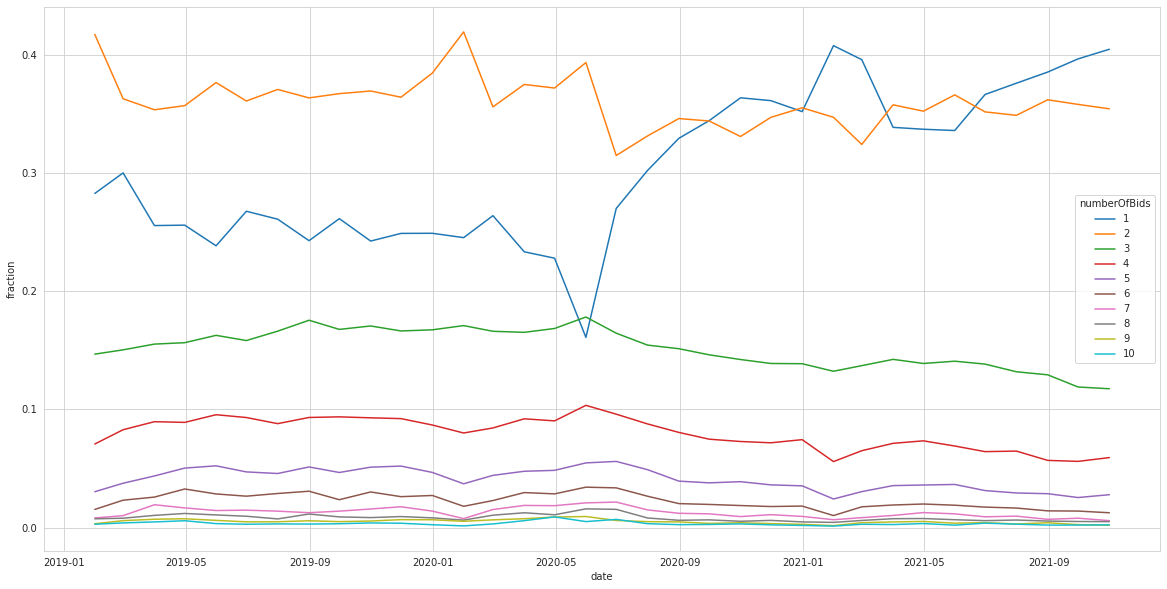

In [ ]:
data_h3_plot = data_h3[data_h3["numberOfBids"] <= 10]

plt.figure(figsize=(20, 10))
sns.lineplot(data=data_h3_plot, x="date", y="fraction", hue="numberOfBids", palette=sns.color_palette("tab10"))

## Hypothesis #4

## Example Economy

In [ ]:
# TO SHOW
# tender bids lots awards
# items
# dk021, geo

In [ ]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9'][['id', 'lots_id',  'bids_id', 'items_code', 'items_classification_l1', 'items_classification_l2', 'items_classification_l3', 'numberOfBids', 'num_lots',  'awards_status', 'status', 'value_amount', 'bids_value_amount', 'awards_value_amount']]

,id,lots_id,bids_id,items_code,items_classification_l1,items_classification_l2,items_classification_l3,numberOfBids,num_lots,awards_status,status,value_amount,bids_value_amount,awards_value_amount
76067,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1215fd8627904632b2771d21998006e5,33141113-4,33000000-0,33100000-1,33140000-3,2,2,NaN,complete,1060036.0,1052085.85,NaN
76068,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,15935b3d80944ce2b1fa5bdc63bcc5d3,33141113-4,33000000-0,33100000-1,33140000-3,2,2,active,complete,1060036.0,1019377.02,1019377.02
76069,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,1215fd8627904632b2771d21998006e5,33140000-3,33000000-0,33100000-1,33140000-3,2,2,NaN,complete,2270252.0,2267523.67,NaN
76070,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,15935b3d80944ce2b1fa5bdc63bcc5d3,33140000-3,33000000-0,33100000-1,33140000-3,2,2,active,complete,2270252.0,2266848.50,2266848.50


In [ ]:
classifier = DK021.load('./data/dk021.csv')

In [ ]:
(
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .assign(
        economy = lambda d: d.value_amount - d.awards_value_amount,
        est_economy = lambda d: d.value_amount - d.value_amount*0.65
    )
)[['economy', 'est_economy']].astype(np.int64).sum()

economy        132597677057
est_economy    546155392707
dtype: int64

In [ ]:
cnt_eco=(
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) /d.value_amount
    )
    .groupby(by=['numberOfBids'])
    .agg({
        'id': 'count',
        'economy': 'mean',
        'value_amount': sum,
        'awards_value_amount': sum
    })
    .reset_index()
    .rename(columns={'id':'cnt'})
    .query('cnt>1000')
    .sort_values(by='numberOfBids')
    .assign(
        count_log = lambda d: np.log2(d.cnt)*15
    )
)
cnt_eco

,numberOfBids,cnt,economy,value_amount,awards_value_amount,count_log
0,1,272064,4.818293,5.545546e+10,5.364767e+10,270.803798
1,2,300337,10.025346,8.612403e+11,8.116753e+11,272.943340
2,3,120906,18.662282,3.106225e+11,2.792178e+11,253.252895
3,4,59413,23.539578,1.292211e+11,1.112743e+11,237.877365
4,5,28961,28.048722,7.365568e+10,6.141915e+10,222.327357
5,6,14807,30.416978,2.792069e+10,2.291922e+10,207.809876
6,7,7794,33.004112,2.568979e+10,2.031637e+10,193.922223
7,8,4498,33.923021,2.605870e+10,2.308378e+10,182.026019
8,9,2469,35.615195,8.148888e+09,6.866796e+09,169.045667
9,10,1461,36.696603,8.343116e+09,7.052200e+09,157.691107


In [ ]:
avg_eco = 100*(cnt_eco.value_amount.sum() - cnt_eco.awards_value_amount.sum()) / cnt_eco.value_amount.sum()
avg_eco

8.443876365284083

In [ ]:
avg_eco_at_5 = cnt_eco[cnt_eco.numberOfBids == 5].economy.iloc[0]
avg_eco_at_5

28.048721521108288

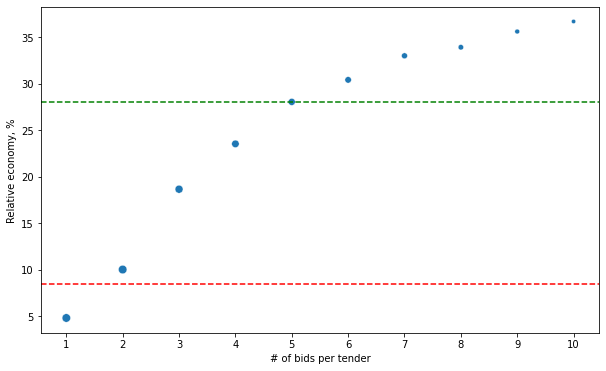

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(avg_eco, ls='--', color='red')
ax.axhline(avg_eco_at_5, ls='--', color='green')
ax = sns.scatterplot(ax=ax, data=cnt_eco, x="numberOfBids", palette="deep", y="economy", size='count_log', legend=False)
ax.set_xlabel('# of bids per tender')
ax.set_ylabel('Relative economy, %')
ax.set_xticks(cnt_eco.numberOfBids.to_list());